<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [15]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [16]:
df = pd.read_csv('data/job_listings.csv')

# reading in the csv into a dataframe

In [17]:
df.head()

# viewing the first 5 rows of the dataframe to get an idea of what we're working with

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [18]:
from bs4 import BeautifulSoup
import requests


def clean_description(desc):
    soup = BeautifulSoup(desc)
    return soup.get_text()

df['clean_desc'] = df['description'].apply(clean_description)

In [19]:
df.head()

,Unnamed: 0,description,title,clean_desc
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"b""Job Requirements:\nConceptual understanding ..."
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"b'Job Description\n\nAs a Data Scientist 1, yo..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,b'As a Data Scientist you will be working on c...
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"b'$4,969 - $6,756 a monthContractUnder the gen..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,b'Location: USA \xe2\x80\x93 multiple location...


## 2) Use Spacy to tokenize the listings 

In [46]:
def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
    tokens = re.sub('[^a-zA-Z 0-9]', ' ', text)
    tokens = tokens.lower().split()
    
    return tokens

In [47]:
df['tokens'] = df['clean_desc'].apply(tokenize)

In [48]:
df.head()

,Unnamed: 0,description,title,clean_desc,tokens,tokens2
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"b""Job Requirements:\nConceptual understanding ...","[b, job, requirements, nconceptual, understand...","[b""job, requirements:\nconceptual, understandi..."
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"b'Job Description\n\nAs a Data Scientist 1, yo...","[b, job, description, n, nas, a, data, scienti...","[b'job, description\n\nas, data, scientist, 1,..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,b'As a Data Scientist you will be working on c...,"[b, as, a, data, scientist, you, will, be, wor...","[b'as, data, scientist, working, consulting, b..."
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"b'$4,969 - $6,756 a monthContractUnder the gen...","[b, 4, 969, 6, 756, a, monthcontractunder, the...","[b'$4,969, -, $6,756, monthcontractunder, gene..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,b'Location: USA \xe2\x80\x93 multiple location...,"[b, location, usa, xe2, x80, x93, multiple, lo...","[b'location:, usa, \xe2\x80\x93, multiple, loc..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [49]:
# Apply CountVectorizer to our Data
# Use custom Spacy Vectorizer
# BBC articles in `data` variable

vect = CountVectorizer(stop_words='english', 
                       max_df=.95,
                       max_features=1500, 
                       ngram_range=(1,2),
                       tokenizer=tokenize
                      )

#Learn our Vocab
vect.fit(df)

# Get sparse dtm
dtm = vect.transform(df)

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
print(f"Number of Features: {dtm.shape[1]}")

Number of Features: 10


/home/cjmckay7/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


## 4) Visualize the most common word counts

In [50]:
df.head()

,Unnamed: 0,description,title,clean_desc,tokens,tokens2
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"b""Job Requirements:\nConceptual understanding ...","[b, job, requirements, nconceptual, understand...","[b""job, requirements:\nconceptual, understandi..."
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"b'Job Description\n\nAs a Data Scientist 1, yo...","[b, job, description, n, nas, a, data, scienti...","[b'job, description\n\nas, data, scientist, 1,..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,b'As a Data Scientist you will be working on c...,"[b, as, a, data, scientist, you, will, be, wor...","[b'as, data, scientist, working, consulting, b..."
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"b'$4,969 - $6,756 a monthContractUnder the gen...","[b, 4, 969, 6, 756, a, monthcontractunder, the...","[b'$4,969, -, $6,756, monthcontractunder, gene..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,b'Location: USA \xe2\x80\x93 multiple location...,"[b, location, usa, xe2, x80, x93, multiple, lo...","[b'location:, usa, \xe2\x80\x93, multiple, loc..."


In [51]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [52]:
STOP_WORDS = nlp.Defaults.stop_words

In [53]:
tokens = []

for doc in tokenizer.pipe(df['clean_desc'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
df['tokens2'] = tokens

In [54]:
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [55]:
wc = count(df['tokens2'])
wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
7,data,419,3751,1.0,0.029743,0.029743,0.983568
275,business,303,1008,2.0,0.007993,0.037736,0.711268
28,experience,357,941,3.0,0.007462,0.045197,0.838028
21,work,326,876,4.0,0.006946,0.052143,0.765258
77,team,314,726,5.0,0.005757,0.057900,0.737089
46,machine,269,660,6.0,0.005233,0.063133,0.631455
22,learning,265,640,7.0,0.005075,0.068208,0.622066
13,science,229,564,8.0,0.004472,0.072680,0.537559
387,statistical,256,531,9.0,0.004210,0.076891,0.600939
106,new,242,517,10.0,0.004099,0.080990,0.568075


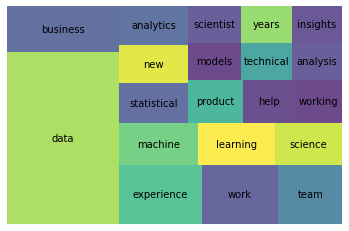

In [56]:
import squarify

wc = count(df['tokens2'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,3))

# Create a vocabulary and get word counts per document
# Similiar to fit_predict
dtm = tfidf.fit_transform(df)

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,clean_desc,description,title,tokens,tokens2,unnamed
0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0


In [58]:
dtm.shape

(6, 6)

## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [59]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [61]:
nn.kneighbors([dtm.iloc[2].values])

(array([[0.        , 1.41421356, 1.41421356, 1.41421356, 1.41421356]]),
 array([[2, 1, 3, 4, 0]]))

In [64]:
# query

nn.kneighbors([dtm.iloc[2]])

(array([[0.        , 1.41421356, 1.41421356, 1.41421356, 1.41421356]]),
 array([[2, 1, 3, 4, 0]]))

In [ ]:
## sorry not completed yet, I definitely need to reiterate through the entire
# assignment at least once more

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 